In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
import statsmodels.api as sm

In [3]:
sys.path.insert(1,'../../scripts/03_plant_optimization/')

In [4]:
import plant_optimization as pop
from plant_optimization.notebook_tools import *

In [5]:
europe_grid = gpd.read_file('../../results_samples/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_grid['sea_node'] = europe_grid.sea_node.astype(bool)
europe_borders = gpd.read_file('../../results_samples/Europe_WGS84.shp')

In [6]:
sensitivity_results_path = os.path.join('../../results/sensitivity') # Points to the location of the results csv files
results_path = os.path.join('../../results/02_plant_optimization') # Points to the location of the results csv files

In [8]:
specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs_names = specs.index

# Load Results

In [90]:
# Load all sensitivity results files into a single dataframe
sensitivity = pd.DataFrame()
for file_glob in glob(f'{sensitivity_results_path}/sensitivity*.csv'): 
    sensitivity = sensitivity.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    
# Load all optimization results (with 2020 parameters) into a single dataframe
countries = europe_grid.country.unique()
results_2020 = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['country'] = country
    results_2020 = results_2020.append(df) 

# Merge the above two dataframes
combined = sensitivity.merge(results_2020,on=['lat','lon','shore_designation'],how='left',suffixes=('_sensi','_2020'))
# NOTE: THE FOLLOWING LINE SHOULD BE USED INSTEAD OF THE ONE ABOVE ONCE THE SENSITIVITY RESULTS INCLUDE THE COUNTRY NAME
# combined = gpd.GeoDataFrame(sensitivity.merge(results_2020,on=['lat','lon','country','offshore_designation'],how='left'))
combined['sea_node'] = combined.apply(lambda x: True if x.shore_designation=='offshore' else False, axis=1)
combined_gdf = gpd.GeoDataFrame(combined.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

# Normalize the LCOF found n the sensitivty analysis relative to that found for the 2020 parameters
combined_gdf['LCOF_liter_norm'] = combined_gdf.LCOF_liter_sensi/combined_gdf.LCOF_liter_2020
combined_gdf['wind_CAPEX'] = combined_gdf.apply(lambda x: x[f'wind_{x.wind_class}_CAPEX']/specs.at[f'wind_{x.wind_class}_CAPEX','value_2020'],axis=1)
combined_gdf['wind_OPEX'] = combined_gdf.apply(lambda x: x[f'wind_{x.wind_class}_OPEX']/specs.at[f'wind_{x.wind_class}_OPEX','value_2020'],axis=1)
combined_gdf.drop(columns=['wind_lo_CAPEX','wind_lo_OPEX','wind_mid_CAPEX','wind_mid_OPEX','wind_hi_CAPEX','wind_hi_OPEX','wind_monopole_CAPEX','wind_monopole_OPEX','wind_jacket_CAPEX','wind_jacket_OPEX','wind_floating_CAPEX','wind_floating_OPEX'],
                  inplace=True)

# Identify correlations

In [100]:
eval_params = [x for x in combined_gdf.columns if x in specs_names or x in ['wind_CAPEX','wind_OPEX']]
eval_params = [x for x in eval_params if combined_gdf[x].max()!=combined_gdf[x].min()]
eval_params = [x for x in eval_params if combined_gdf[x].isna().sum()==0]
ols_reg = pd.DataFrame()
for eval_param in eval_params:
    X = combined_gdf[eval_param]
    Y = combined_gdf.LCOF_liter_norm
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    ols_reg = ols_reg.append({'parameter':eval_param,'const':results.params.const,'slope':results.params[eval_param],'rsquared':results.rsquared,'rsquared_adj':results.rsquared_adj},ignore_index=True)
ols_reg = ols_reg[['parameter','slope','const','rsquared','rsquared_adj']]

In [191]:
ols_reg.sort_values('rsquared',ascending=False).head(5)

,parameter,slope,const,rsquared,rsquared_adj
27,wind_CAPEX,0.421811,0.579947,0.188788,0.187543
10,H2tL_chem_efficiency,-1.562003,2.016258,0.182325,0.181071
21,electrolyzer_efficiency,-1.093151,1.657198,0.076256,0.074839
25,wind_lifetime,-0.011637,1.292167,0.072595,0.071172
9,H2tL_baseload,0.273947,0.780243,0.064957,0.063523


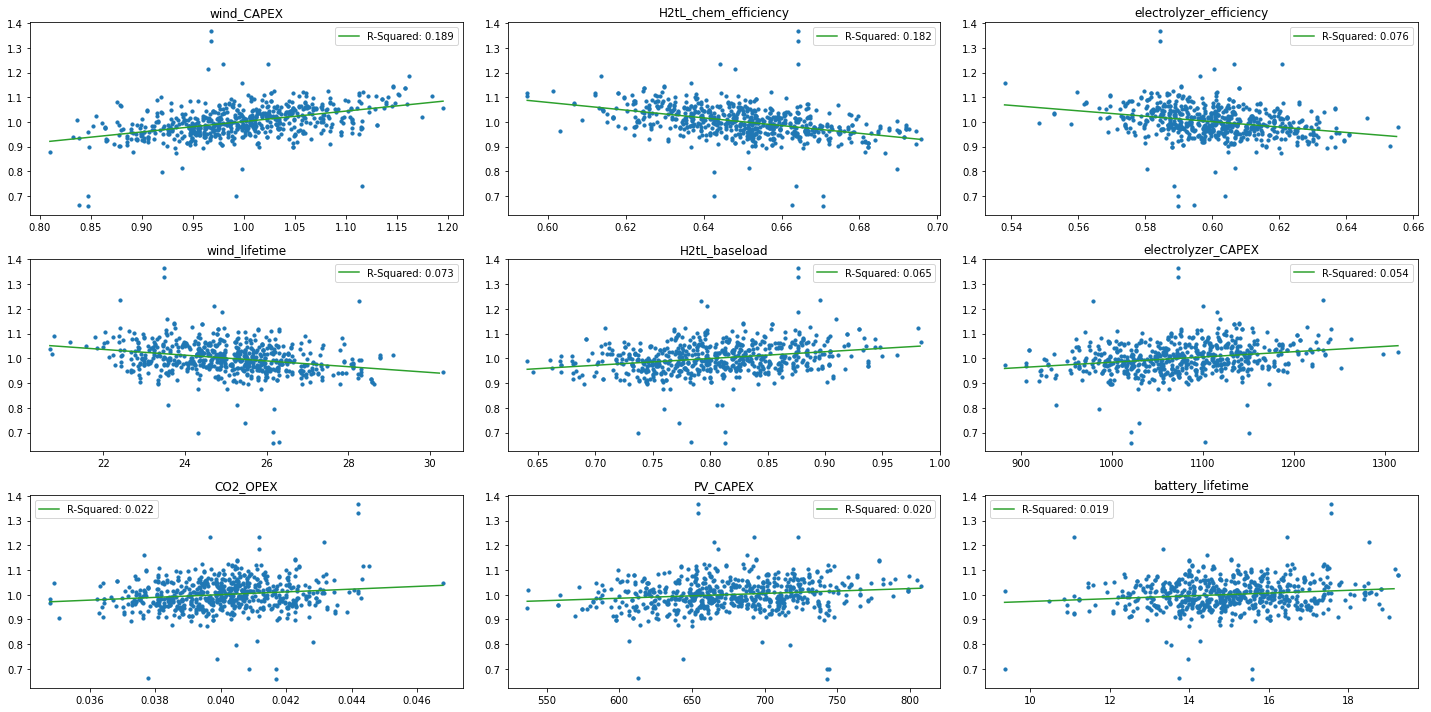

In [189]:
figsize=(20,10)
params_count = 9
ncols=3
df = combined_gdf.copy()
ols_reg_slice = ols_reg.sort_values('rsquared',ascending=False).iloc[:params_count].reset_index(drop=True).copy()

if ncols == None:
    ncols = int(np.ceil(np.sqrt(params_count)))
nrows = int(np.ceil(params_count/ncols))    
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
axes = np.reshape(axes,(1,nrows*ncols))[0]
for idx,row in ols_reg_slice.iterrows():
    axes[idx].scatter(df[row.parameter],df.LCOF_liter_norm,s=10)
    maxx = df[row.parameter].max()
    minx = df[row.parameter].min()
    x = np.arange(minx,maxx,round((maxx-minx)/100,5))
    y = row.slope*x + row.const
    axes[idx].plot(x,y,color='C2',label=f'R-Squared: {row.rsquared:.3f}')
    axes[idx].set_title(row.parameter)
    axes[idx].legend()
plt.tight_layout()
# plt.savefig('../../gfx/highest_sensitivities.png',dpi=400)

# Normalize 

In [100]:
eval_params = [x for x in combined_gdf.columns if x in specs_names or x in ['wind_CAPEX','wind_OPEX']]
eval_params = [x for x in eval_params if combined_gdf[x].max()!=combined_gdf[x].min()]
eval_params = [x for x in eval_params if combined_gdf[x].isna().sum()==0]
ols_reg = pd.DataFrame()
for eval_param in eval_params:
    X = combined_gdf[eval_param]
    Y = combined_gdf.LCOF_liter_norm
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    ols_reg = ols_reg.append({'parameter':eval_param,'const':results.params.const,'slope':results.params[eval_param],'rsquared':results.rsquared,'rsquared_adj':results.rsquared_adj},ignore_index=True)
ols_reg = ols_reg[['parameter','slope','const','rsquared','rsquared_adj']]

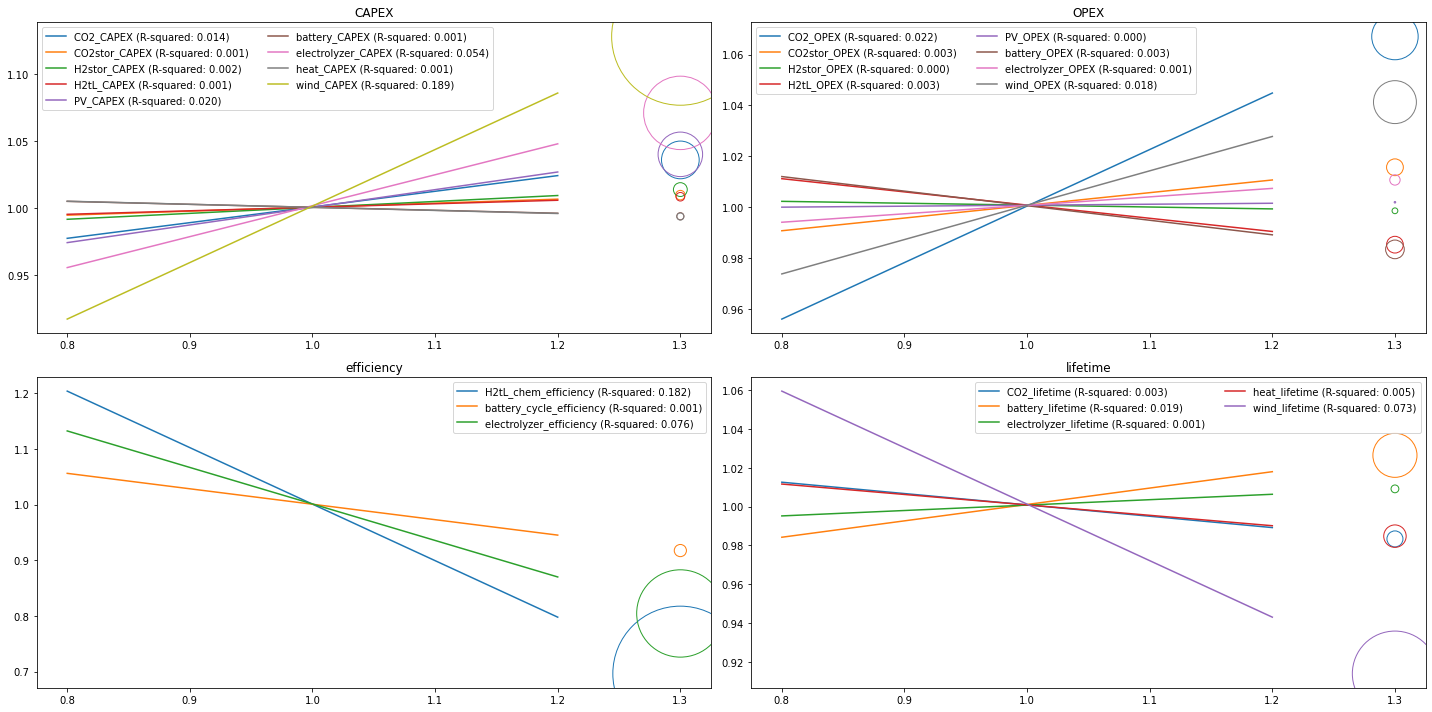

In [190]:
figsize=(20,10)
param_groups = {'CAPEX':[],'OPEX':[],'efficiency':[],'lifetime':[]}
ncols=None
xspan = 0.3
for key in param_groups.keys():
    param_groups[key] = [x for x in ols_reg.parameter if key in x]
    
if ncols == None:
    ncols = int(np.ceil(np.sqrt(len(param_groups))))
nrows = int(np.ceil(len(param_groups)/ncols))  

fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
axes = np.reshape(axes,(1,len(param_groups)))[0]
for i,(param_group,parameters) in enumerate(param_groups.items()):
    max_rsquared = ols_reg.loc[ols_reg.parameter.isin(parameters),'rsquared'].sort_values(ascending=False).iloc[0]
    for j,parameter in enumerate(parameters):
        if parameter=='wind_CAPEX' or parameter=='wind_OPEX':
            normed_slope = ols_reg.loc[ols_reg.parameter==parameter,'slope'].item()
        else:        
            normed_slope = ols_reg.loc[ols_reg.parameter==parameter,'slope'].item()*specs.at[parameter,'value_2020']
        rsquared = ols_reg.loc[ols_reg.parameter==parameter,'rsquared'].item()
#         x = np.arange(1-xspan*rsquared/max_rsquared,1+xspan*rsquared/max_rsquared+.001,0.001)
        x = np.arange(0.8,1.3,0.1)
        y = normed_slope*x + ols_reg.loc[ols_reg.parameter==parameter,'const'].item()
        rsquared_markx = np.array([1.3])
        rsquared_marky = normed_slope*rsquared_markx + ols_reg.loc[ols_reg.parameter==parameter,'const'].item()
        dash_bins = []
        axes[i].plot(x,y,color=f'C{j}',label=f'{parameter} (R-squared: {rsquared:.3f})')
        axes[i].scatter(rsquared_markx,rsquared_marky,color=f'C{j}',facecolors='none',s=rsquared*1e5)
    axes[i].legend(ncol=2 if len(parameters)>3 else 1)
    axes[i].set_title(param_group)
plt.tight_layout()
# plt.savefig('../../gfx/parameter_sensitivity.png',dpi=400)